# アンサンブル学習

## 【事前準備】

In [1]:
# scikit-learnの「set_config(display="diagram")」を使用するため、scikitlearnを最新verに更新
# !pip install scikit-learn==0.23.2 --target drive/My\ Drive/MyModule
# !pip install scikit-learn==0.23.2
# !pip list
## Google Drive上にインストールしたモジュールのインポート##
import sys
sys.path.append('/content/drive/My Drive/MyModule')

In [2]:
## モジュールのインポート ##
# 一般
import random
import math
# データ分析
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style
%matplotlib inline
matplotlib.style.use('ggplot')
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
# 決定木可視化のためのツール
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
# その他
from google.colab import drive #GoogleDriveモジュール
drive.mount('/content/drive') #GoogleDriveのマウント

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


## 【実装】

### ●動作確認に使用するデータセットの準備（住宅価格予測で使用したデータセットを使用）

In [3]:
csv_path = "drive/My Drive/DIVE INTO CODE/Week3/train.csv" # ファイル名（パス）を指定する

import pandas as pd
df_train_org = pd.read_csv(csv_path)

# df_train = df_train_org.iloc[:10000, :]   #データ数を削減
df_train = df_train_org

#GrLivArea、YearBuilt、SalePrice列のみを抽出
df_train = df_train.loc[:, ["GrLivArea", "YearBuilt", "SalePrice"]]

pd.set_option('display.max_rows', 150)    #最大表示行数を設定
pd.set_option('display.max_columns', 5)   #最大表示列数を設定

display(df_train)

,GrLivArea,YearBuilt,SalePrice
0,1710,2003,208500
1,1262,1976,181500
2,1786,2001,223500
3,1717,1915,140000
4,2198,2000,250000
...,...,...,...
1455,1647,1999,175000
1456,2073,1978,210000
1457,2340,1941,266500
1458,1078,1950,142125


,GrLivArea,YearBuilt,SalePrice
GrLivArea,1.000000,0.199010,0.708624
YearBuilt,0.199010,1.000000,0.522897
SalePrice,0.708624,0.522897,1.000000


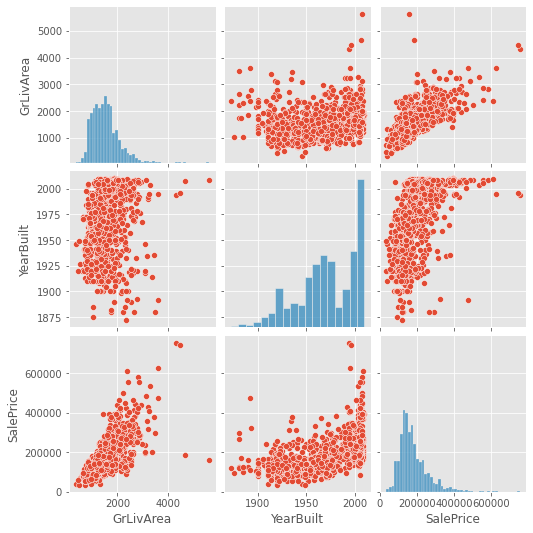

In [4]:
#相関係数
display(df_train.corr())

#散布図行列を作成
sns.pairplot(df_train, diag_kind="hist");

In [5]:
X = np.array(df_train.iloc[:, :-1])
y = np.array(df_train.iloc[:, -1])

#データセットを学習用と検証用に分割
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, train_size = 0.75, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train1)
X_train1_transformed = scaler.transform(X_train1)
X_test1_transformed = scaler.transform(X_test1)

X_train1_1, X_train1_2, y_train1_1, y_train1_2 = train_test_split(X_train1_transformed, y_train1, train_size = 0.75, random_state=0)

## 【問題1】ブレンディングのスクラッチ実装
ブレンディング をスクラッチ実装し、単一モデルより精度があがる例を 最低3つ 示してください。精度があがるとは、検証データに対する平均二乗誤差（MSE）が小さくなることを指します。


**ブレンディングとは**<br>
ブレンディングとは、N個の多様なモデルを独立して学習させ、推定結果を重み付けした上で足し合わせる方法です。最も単純には平均をとります。多様なモデルとは、以下のような条件を変化させることで作り出すものです。


- 手法（例：線形回帰、SVM、決定木、ニューラルネットワークなど）
- ハイパーパラメータ（例：SVMのカーネルの種類、重みの初期値など）
- 入力データの前処理の仕方（例：標準化、対数変換、PCAなど）

重要なのはそれぞれのモデルが大きく異なることです。


回帰問題でのブレンディングは非常に単純であるため、scikit-learnには用意されていません。


《補足》


分類問題の場合は、多数決を行います。回帰問題に比べると複雑なため、scikit-learnにはVotingClassifierが用意されています。

### ●SGDRegressorクラスによる線形回帰

y_predict:
[179007.79792642 198786.11132542 135650.75829207 ... 157777.26821064
 121559.66934773 122575.54641143]


y_test(true):
[170000 232000 145000 ... 140000  88000 122000]


coef_ =
[40639.47594614 31047.57665384]
intercept_
[156366.55580462]
mean_scored_error(RMSE):
53797.53713404219
mean_absolute_error(MAE):
35538.384439185465


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


,LinearRegression
coef_[0],40639.5
coef_[1],31047.6
intercept_,[156366.55580461744]
RMSE,53797.5
MAE,35538.4


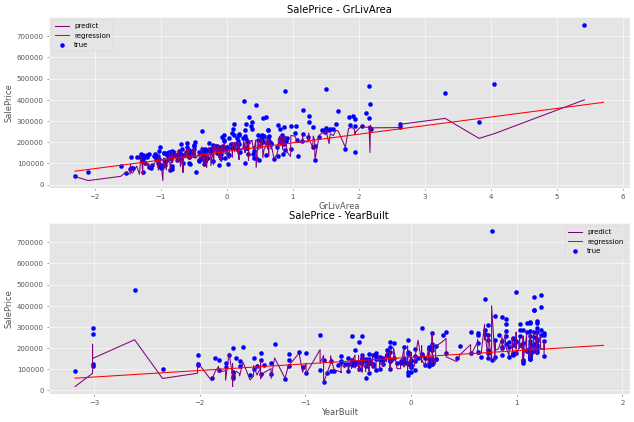

In [6]:
# clf = LinearRegression()
clf = SGDRegressor(loss="squared_loss", max_iter=1, tol=1e-3, random_state=0)

X = X_train1_1
Xt = X_train1_2
y = y_train1_1
yt = y_train1_2

np.set_printoptions(threshold=100)    #ndarrayの要素の表示数上限を設定

# データセットに対して学習・推定・評価
clf.fit(X, y)
y_predict = clf.predict(Xt)
print("y_predict:")
print(y_predict)
print("\n")
print("y_test(true):")
print(yt)


print("\n")
print("coef_ =")
print(clf.coef_)
print("intercept_")
print(clf.intercept_)   # 切片

#評価
mean_scored_error_linear = mean_squared_error(yt, y_predict, squared=False)   #RMSE
# mean_scored_error_linear = mean_squared_error(yt, y_predict, squared=True)   #MSE
print("mean_scored_error(RMSE):")
print(mean_scored_error_linear)
mean_absolute_error_linear = mean_absolute_error(yt, y_predict)   #RMSE
print("mean_absolute_error(MAE):")
print(mean_absolute_error_linear)

pd.set_option("display.max_columns", 300)   #列数の表示上限を指定

# パラメータや推定精度をスコアボードに記録
df_score = pd.DataFrame(data=[])
df_score_temp = pd.DataFrame(
    [clf.coef_[0],    # 係数
     clf.coef_[1],    # 係数
     clf.intercept_,    # 切片
     mean_scored_error_linear,   # RMSE
     mean_absolute_error_linear],   # MAE
     index=["coef_[0]", "coef_[1]", "intercept_", "RMSE", "MAE"], 
     columns=["LinearRegression"])
df_score = pd.concat([df_score, df_score_temp], axis=1)
display(df_score)


#予測値と実測値をプロット
fig3, ax3 = plt.subplots(2, figsize=(15, 10), dpi=50)

ax3[0].set_title("SalePrice - GrLivArea")
ax3[0].set_xlabel("GrLivArea")
ax3[0].set_ylabel("SalePrice")
ax3[1].set_title("SalePrice - YearBuilt")
ax3[1].set_xlabel("YearBuilt")
ax3[1].set_ylabel("SalePrice")



#実測値をプロット（散布図）
ax3[0].scatter(Xt[:, 0], yt, c="blue", cmap='Blues', label="true")
ax3[1].scatter(Xt[:, 1], yt, c="blue", cmap='Blues', label="true")

#予測値をプロット（折れ線）
X_y_ndarray = np.concatenate([Xt, y_predict.reshape(-1, 1)], axis=1)
X_y_sort_col0_ndarray = X_y_ndarray[np.argsort(X_y_ndarray[:, 0])]  #0列目(X1)でソート
X_y_sort_col1_ndarray = X_y_ndarray[np.argsort(X_y_ndarray[:, 1])]  #1列目(X2)でソート
ax3[0].plot(X_y_sort_col0_ndarray[:, 0], X_y_sort_col0_ndarray[:, 2], color = "purple", label="predict")
ax3[0].legend(loc='best') # 凡例を最適位置に表示
ax3[1].plot(X_y_sort_col1_ndarray[:, 1], X_y_sort_col1_ndarray[:, 2], color = "purple", label="predict")
ax3[1].legend(loc='best') # 凡例を最適位置に表示

#回帰直線を作成
X1 = np.arange(np.min(Xt[:, 0]), np.max(Xt[:, 0]) + 1, 1)
y_predict_regression = clf.coef_[0] * X1 + clf.intercept_
ax3[0].plot(X1, y_predict_regression, color = "red", label="regression")
ax3[0].legend(loc='best') # 凡例を最適位置に表示
X2 = np.arange(np.min(Xt[:, 1]), np.max(Xt[:, 1]) + 1, 1)
y_predict_regression = clf.coef_[1] * X2 + clf.intercept_
ax3[1].plot(X2, y_predict_regression, color = "red", label="regression")
ax3[1].legend(loc='best') # 凡例を最適位置に表示

plt.show()

# ブレンディングの前準備
clf_predict_list = [(clf, y_predict)]
mse_list = [mean_scored_error_linear]
mae_list = [mean_absolute_error_linear]

### ●SVRによる線形回帰

y_predict:
[193013.96824544 211439.79261581 154207.84804302 ... 172499.57328022
 140855.06125059 147099.41407568]


y_test(true):
[170000 232000 145000 ... 140000  88000 122000]


coef_ =
[[38763.74590993 26960.03280173]]
intercept_
[173966.93819987]
mean_scored_error(RMSE):
48613.76891140487
mean_absolute_error(MAE):
30379.673621870472


,LinearRegression,SVR
coef_[0],40639.5,38763.7
coef_[1],31047.6,26960
intercept_,[156366.55580461744],[173966.93819986694]
RMSE,53797.5,48613.8
MAE,35538.4,30379.7


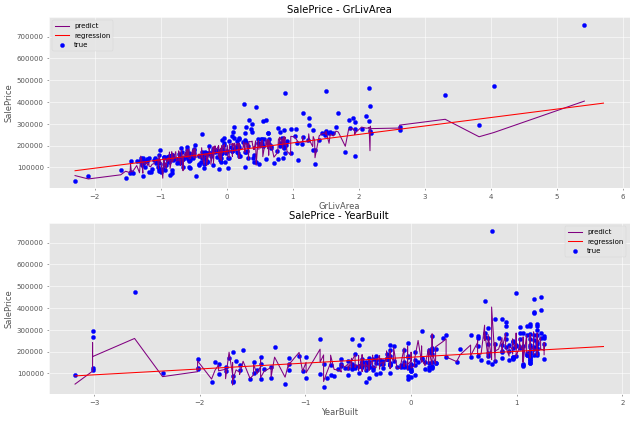

In [7]:
clf = SVR(kernel="linear", C=1000, epsilon=0.1)   #カーネル関数：線形、正則化項C：1000、スラック変数：0.2

X = X_train1_1
Xt = X_train1_2
y = y_train1_1
yt = y_train1_2

np.set_printoptions(threshold=100)    #ndarrayの要素の表示数上限を設定

# データセットに対して学習・推定・評価
clf.fit(X, y)
y_predict = clf.predict(Xt)
print("y_predict:")
print(y_predict)
print("\n")
print("y_test(true):")
print(yt)


print("\n")
print("coef_ =")
print(clf.coef_)
print("intercept_")
print(clf.intercept_)   # 切片

#評価
mean_scored_error_linear = mean_squared_error(yt, y_predict, squared=False)   #RMSE
# mean_scored_error_linear = mean_squared_error(yt, y_predict, squared=True)   #MSE
print("mean_scored_error(RMSE):")
print(mean_scored_error_linear)
mean_absolute_error_linear = mean_absolute_error(yt, y_predict)   #RMSE
print("mean_absolute_error(MAE):")
print(mean_absolute_error_linear)

pd.set_option("display.max_columns", 300)   #列数の表示上限を指定

# パラメータや推定精度をスコアボードに記録
# df_score = pd.DataFrame(data=[])
df_score_temp = pd.DataFrame(
    [clf.coef_[0, 0],    # 係数
     clf.coef_[0, 1],    # 係数
     clf.intercept_,    # 切片
     mean_scored_error_linear,   # RMSE
     mean_absolute_error_linear],   # MAE
     index=["coef_[0]", "coef_[1]", "intercept_", "RMSE", "MAE"], 
     columns=["SVR"])
df_score = pd.concat([df_score, df_score_temp], axis=1)
display(df_score)


#予測値と実測値をプロット
fig3, ax3 = plt.subplots(2, figsize=(15, 10), dpi=50)

ax3[0].set_title("SalePrice - GrLivArea")
ax3[0].set_xlabel("GrLivArea")
ax3[0].set_ylabel("SalePrice")
ax3[1].set_title("SalePrice - YearBuilt")
ax3[1].set_xlabel("YearBuilt")
ax3[1].set_ylabel("SalePrice")



#実測値をプロット（散布図）
ax3[0].scatter(Xt[:, 0], yt, c="blue", cmap='Blues', label="true")
ax3[1].scatter(Xt[:, 1], yt, c="blue", cmap='Blues', label="true")

#予測値をプロット（折れ線）
X_y_ndarray = np.concatenate([Xt, y_predict.reshape(-1, 1)], axis=1)
X_y_sort_col0_ndarray = X_y_ndarray[np.argsort(X_y_ndarray[:, 0])]  #0列目(X1)でソート
X_y_sort_col1_ndarray = X_y_ndarray[np.argsort(X_y_ndarray[:, 1])]  #1列目(X2)でソート
ax3[0].plot(X_y_sort_col0_ndarray[:, 0], X_y_sort_col0_ndarray[:, 2], color = "purple", label="predict")
ax3[0].legend(loc='best') # 凡例を最適位置に表示
ax3[1].plot(X_y_sort_col1_ndarray[:, 1], X_y_sort_col1_ndarray[:, 2], color = "purple", label="predict")
ax3[1].legend(loc='best') # 凡例を最適位置に表示

#回帰直線を作成
X1 = np.arange(np.min(Xt[:, 0]), np.max(Xt[:, 0]) + 1, 1)
y_predict_regression = clf.coef_[0, 0] * X1 + clf.intercept_[0]
ax3[0].plot(X1, y_predict_regression, color = "red", label="regression")
ax3[0].legend(loc='best') # 凡例を最適位置に表示
X2 = np.arange(np.min(Xt[:, 1]), np.max(Xt[:, 1]) + 1, 1)
y_predict_regression = clf.coef_[0, 1] * X2 + clf.intercept_[0]
ax3[1].plot(X2, y_predict_regression, color = "red", label="regression")
ax3[1].legend(loc='best') # 凡例を最適位置に表示

plt.show()

# ブレンディングの前準備
clf_predict_list.append((clf, y_predict))
mse_list.append(mean_scored_error_linear)

### ●決定木による線形回帰

y_predict:
[180000. 221500. 175500. ... 155000. 138800. 163000.]


y_test(true):
[170000 232000 145000 ... 140000  88000 122000]


feature_importances_ =
[0.49111664 0.50888336]
mean_scored_error(RMSE):
63972.15331968797
mean_absolute_error(MAE):
39566.62773722628


,LinearRegression,SVR,DecisionTree
coef_[0],40639.5,38763.7,NaN
coef_[1],31047.6,26960,NaN
intercept_,[156366.55580461744],[173966.93819986694],NaN
RMSE,53797.5,48613.8,63972.153320
MAE,35538.4,30379.7,39566.627737


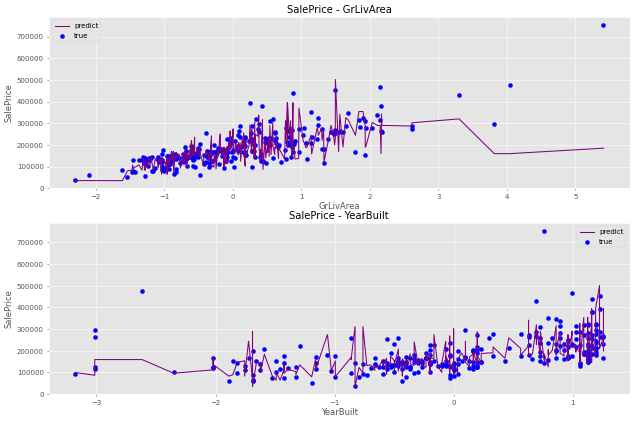

In [8]:
clf = DecisionTreeRegressor(random_state=0)

X = X_train1_1
Xt = X_train1_2
y = y_train1_1
yt = y_train1_2

np.set_printoptions(threshold=100)    #ndarrayの要素の表示数上限を設定

# データセットに対して学習・推定・評価
clf.fit(X, y)
y_predict = clf.predict(Xt)
print("y_predict:")
print(y_predict)
print("\n")
print("y_test(true):")
print(yt)


print("\n")
# print("coef_ =")
# print(clf.coef_)
# print("intercept_")
# print(clf.intercept_)   # 切片
print("feature_importances_ =")
print(clf.feature_importances_)

#評価
mean_scored_error_linear = mean_squared_error(yt, y_predict, squared=False)   #RMSE
# mean_scored_error_linear = mean_squared_error(yt, y_predict, squared=True)   #MSE
print("mean_scored_error(RMSE):")
print(mean_scored_error_linear)
mean_absolute_error_linear = mean_absolute_error(yt, y_predict)   #MAE
print("mean_absolute_error(MAE):")
print(mean_absolute_error_linear)

pd.set_option("display.max_columns", 300)   #列数の表示上限を指定

# パラメータや推定精度をスコアボードに記録
# df_score = pd.DataFrame(data=[])
df_score_temp = pd.DataFrame(
    # [clf.coef_[0],    # 係数
    #  clf.coef_[1],    # 係数
    #  clf.intercept_,    # 切片
     [mean_scored_error_linear,   # RMSE
     mean_absolute_error_linear],   # MAE
     index=["RMSE", "MAE"], 
     columns=["DecisionTree"])
df_score = pd.concat([df_score, df_score_temp], axis=1)
display(df_score)


#予測値と実測値をプロット
fig3, ax3 = plt.subplots(2, figsize=(15, 10), dpi=50)

ax3[0].set_title("SalePrice - GrLivArea")
ax3[0].set_xlabel("GrLivArea")
ax3[0].set_ylabel("SalePrice")
ax3[1].set_title("SalePrice - YearBuilt")
ax3[1].set_xlabel("YearBuilt")
ax3[1].set_ylabel("SalePrice")



#実測値をプロット（散布図）
ax3[0].scatter(Xt[:, 0], yt, c="blue", cmap='Blues', label="true")
ax3[1].scatter(Xt[:, 1], yt, c="blue", cmap='Blues', label="true")

#予測値をプロット（折れ線）
X_y_ndarray = np.concatenate([Xt, y_predict.reshape(-1, 1)], axis=1)
X_y_sort_col0_ndarray = X_y_ndarray[np.argsort(X_y_ndarray[:, 0])]  #0列目(X1)でソート
X_y_sort_col1_ndarray = X_y_ndarray[np.argsort(X_y_ndarray[:, 1])]  #1列目(X2)でソート
ax3[0].plot(X_y_sort_col0_ndarray[:, 0], X_y_sort_col0_ndarray[:, 2], color = "purple", label="predict")
ax3[0].legend(loc='best') # 凡例を最適位置に表示
ax3[1].plot(X_y_sort_col1_ndarray[:, 1], X_y_sort_col1_ndarray[:, 2], color = "purple", label="predict")
ax3[1].legend(loc='best') # 凡例を最適位置に表示

#回帰直線を作成
# X1 = np.arange(np.min(Xt[:, 0]), np.max(Xt[:, 0]) + 1, 1)
# y_predict_regression = clf.coef_[0] * X1 + clf.intercept_
# ax3[0].plot(X1, y_predict_regression, color = "red", label="regression")
# ax3[0].legend(loc='best') # 凡例を最適位置に表示
# X2 = np.arange(np.min(Xt[:, 1]), np.max(Xt[:, 1]) + 1, 1)
# y_predict_regression = clf.coef_[1] * X2 + clf.intercept_
# ax3[1].plot(X2, y_predict_regression, color = "red", label="regression")
# ax3[1].legend(loc='best') # 凡例を最適位置に表示

plt.show()

# ブレンディングの前準備
clf_predict_list.append((clf, y_predict))
mse_list.append(mean_scored_error_linear)

### ●ブレンディング

#### ・【パターン１】単純に各モデルの推定値の平均値を取り、推定値を算出

In [9]:
X = X_train1_2
Xt = X_test1_transformed
y = y_train1_2
yt = y_test1

y_predict_final = np.zeros(len(yt))   # yの推定値を初期化

# 各モデルの推定結果を合算
for clf, y_predict_model in clf_predict_list:
    y_predict = clf.predict(Xt)
    y_predict_final += y_predict

# モデルの数で除算して平均値を算出
y_predict = y_predict_final / len(clf_predict_list)

np.set_printoptions(threshold=100)    #ndarrayの要素の表示数上限を設定

print("y_predict:")
print(y_predict)
print("\n")
print("y_test(true):")
print(yt)
print("\n")

#評価
mean_scored_error_linear = mean_squared_error(yt, y_predict, squared=False)   #RMSE
# mean_scored_error_linear = mean_squared_error(yt, y_predict, squared=True)   #MSE
print("mean_scored_error(RMSE):")
print(mean_scored_error_linear)

# パラメータや推定精度をスコアボードに記録
# df_score = pd.DataFrame(data=[])
df_score_temp = pd.DataFrame(
    # [clf.coef_[0],    # 係数
    #  clf.coef_[1],    # 係数
    #  clf.intercept_,    # 切片
     [mean_scored_error_linear,   # RMSE
     mean_absolute_error_linear],   # MAE
     index=["RMSE", "MAE"], 
     columns=["blending(Simply mean)"])
df_score = pd.concat([df_score, df_score_temp], axis=1)
display(df_score)

y_predict:
[208408.14521321 140473.10563778 122018.24978951 ... 220209.35057016
 193716.58812751  45508.60053526]


y_test(true):
[200624 133000 110000 ... 235000 239000  85000]


mean_scored_error(RMSE):
51830.30447752813


,LinearRegression,SVR,DecisionTree,blending(Simply mean)
coef_[0],40639.5,38763.7,NaN,NaN
coef_[1],31047.6,26960,NaN,NaN
intercept_,[156366.55580461744],[173966.93819986694],NaN,NaN
RMSE,53797.5,48613.8,63972.153320,51830.304478
MAE,35538.4,30379.7,39566.627737,39566.627737


#### ・【パターン２】各モデルのMSEに基づいてモデルごとに重みを決定し、推定値を算出

In [10]:
X = X_train1_2
Xt = X_test1_transformed
y = y_train1_2
yt = y_test1

# 各モデルのMSEの調和平均を算出
mse_hsum = 0    # MSEの調和平均
for mse in mse_list:
    mse_hsum += (1 / mse)

# 各モデルの重みをリスト化
weight_list = []  # 重みのリスト
for mse in mse_list:
    weight = (1 / mse) / mse_hsum
    weight_list.append(weight)

# 各モデルの推定結果を重みづけして合算
y_predict_final = np.zeros(len(yt))   # yの推定値を初期化
for (clf, y_predict_model), weight in zip(clf_predict_list, weight_list):
    y_predict = clf.predict(Xt)
    y_predict_final += y_predict * weight

y_predict = y_predict_final

np.set_printoptions(threshold=100)    #ndarrayの要素の表示数上限を設定

print("y_predict:")
print(y_predict)
print("\n")
print("y_test(true):")
print(yt)
print("\n")

#評価
mean_scored_error_linear = mean_squared_error(yt, y_predict, squared=False)   #RMSE
# mean_scored_error_linear = mean_squared_error(yt, y_predict, squared=True)   #MSE
print("mean_scored_error(RMSE):")
print(mean_scored_error_linear)

# パラメータや推定精度をスコアボードに記録
# df_score = pd.DataFrame(data=[])
df_score_temp = pd.DataFrame(
    # [clf.coef_[0],    # 係数
    #  clf.coef_[1],    # 係数
    #  clf.intercept_,    # 切片
     [mean_scored_error_linear,   # RMSE
     mean_absolute_error_linear],   # MAE
     index=["RMSE", "MAE"], 
     columns=["blending(Weighted by RMSE)"])
df_score = pd.concat([df_score, df_score_temp], axis=1)
display(df_score)

y_predict:
[211534.73291156 140895.29498391 122194.12464592 ... 216581.01919057
 195364.03945482  46788.30706595]


y_test(true):
[200624 133000 110000 ... 235000 239000  85000]


mean_scored_error(RMSE):
51924.15373570091


,LinearRegression,SVR,DecisionTree,blending(Simply mean),blending(Weighted by RMSE)
coef_[0],40639.5,38763.7,NaN,NaN,NaN
coef_[1],31047.6,26960,NaN,NaN,NaN
intercept_,[156366.55580461744],[173966.93819986694],NaN,NaN,NaN
RMSE,53797.5,48613.8,63972.153320,51830.304478,51924.153736
MAE,35538.4,30379.7,39566.627737,39566.627737,39566.627737


#### ・【パターン３】各モデルのMAEに基づいてモデルごとに重みを決定し、推定値を算出

In [11]:
X = X_train1_2
Xt = X_test1_transformed
y = y_train1_2
yt = y_test1

# 各モデルのMAEの調和平均を算出
mae_hsum = 0    # MAEの調和平均
for mae in mae_list:
    mae_hsum += (1 / mae)

# 各モデルの重みをリスト化
weight_list = []  # 重みのリスト
for mae in mae_list:
    weight = (1 / mae) / mae_hsum
    weight_list.append(weight)

# 各モデルの推定結果を重みづけして合算
y_predict_final = np.zeros(len(yt))   # yの推定値を初期化
for (clf, y_predict_model), weight in zip(clf_predict_list, weight_list):
    y_predict = clf.predict(Xt)
    y_predict_final += y_predict * weight

y_predict = y_predict_final

np.set_printoptions(threshold=100)    #ndarrayの要素の表示数上限を設定

print("y_predict:")
print(y_predict)
print("\n")
print("y_test(true):")
print(yt)
print("\n")

#評価
mean_scored_error_linear = mean_squared_error(yt, y_predict, squared=False)   #RMSE
# mean_scored_error_linear = mean_squared_error(yt, y_predict, squared=True)   #MSE
print("mean_scored_error(RMSE):")
print(mean_scored_error_linear)

# パラメータや推定精度をスコアボードに記録
# df_score = pd.DataFrame(data=[])
df_score_temp = pd.DataFrame(
    # [clf.coef_[0],    # 係数
    #  clf.coef_[1],    # 係数
    #  clf.intercept_,    # 切片
     [mean_scored_error_linear,   # RMSE
     mean_absolute_error_linear],   # MAE
     index=["RMSE", "MAE"], 
     columns=["blending(Weighted by MAE)"])
df_score = pd.concat([df_score, df_score_temp], axis=1)
display(df_score)

y_predict:
[220168.69205675 129981.43780399 109727.38979042 ... 186483.46170849
 197301.70767891  36566.06731867]


y_test(true):
[200624 133000 110000 ... 235000 239000  85000]


mean_scored_error(RMSE):
58005.30122898115


,LinearRegression,SVR,DecisionTree,blending(Simply mean),blending(Weighted by RMSE),blending(Weighted by MAE)
coef_[0],40639.5,38763.7,NaN,NaN,NaN,NaN
coef_[1],31047.6,26960,NaN,NaN,NaN,NaN
intercept_,[156366.55580461744],[173966.93819986694],NaN,NaN,NaN,NaN
RMSE,53797.5,48613.8,63972.153320,51830.304478,51924.153736,58005.301229
MAE,35538.4,30379.7,39566.627737,39566.627737,39566.627737,39566.627737


#### ・【ボツ】各モデルの残差（誤差）に基づいて推定値ごとに重みを決定し、推定値を算出

In [12]:
# # 各モデルの推定値と正解値との残差を配列化
# for i, (clf, y_predict_model) in enumerate(clf_predict_list):
#     y_error = (yt - y_predict_model)**2
#     if i == 0:
#         y_error_list = y_error.reshape(-1, 1)
#     else:
#         y_error_list = np.append(y_error_list, y_error.reshape(-1, 1), axis=1)


# # 残差から各推定値の重みをリスト化
# y_error_hsum = (1 / y_error_list).sum(axis=1).reshape(-1, 1)
# weight_list = (1 / y_error_list) / (y_error_hsum)
# weight_list = np.nan_to_num(weight_list, nan=1)   # 0割によって発生したNANを1に置換

# # 各モデルの推定結果を重みづけして合算
# y_predict = np.zeros(len(yt))   # yの推定値を初期化
# for i, (clf, y_predict_model) in enumerate(clf_predict_list):
#     y_predict += y_predict_model * weight_list[:, i]

# np.set_printoptions(threshold=100)    #ndarrayの要素の表示数上限を設定

# print("y_predict:")
# print(y_predict)
# print("\n")
# print("y_test(true):")
# print(yt)
# print("\n")

# #評価
# mean_scored_error_linear = mean_squared_error(yt, y_predict, squared=False)   #RMSE
# print("mean_scored_error(RMSE):")
# print(mean_scored_error_linear)

# # パラメータや推定精度をスコアボードに記録
# # df_score = pd.DataFrame(data=[])
# df_score_temp = pd.DataFrame(
#     # [clf.coef_[0],    # 係数
#     #  clf.coef_[1],    # 係数
#     #  clf.intercept_,    # 切片
#     [mean_scored_error_linear],   # RMSE
#     #  index=["coef_[0]", "coef_[1]", "intercept_", "RMSE"], 
#      index=["RMSE"], 
#      columns=["blending(Weighted by predict value)"])
# df_score = pd.concat([df_score, df_score_temp], axis=1)
# display(df_score)

### 【問題1 解答】
SGDRegressor、SVR、DecisionTreeRegressorの３つを用いて線形回帰を行い、以下の３つのパターンでブレンディングを実施した。
- 【パターン１】単純に各モデルの推定値の平均値を取り、推定値を算出
- 【パターン２】各モデルのRMSEに基づいてモデルごとに重みを決定し、推定値を算出
- 【パターン３】各モデルのMAEに基づいてモデルごとに重みを決定し、推定値を算出


結果としてはいずれのパターンでも、モデル単体で得られた精度の中で最良のものを上回る結果は得られなかった。

## 【問題2】バギングのスクラッチ実装
バギング をスクラッチ実装し、単一モデルより精度があがる例を 最低1つ 示してください。


**バギングとは**<br>
バギングは入力データの選び方を多様化する方法です。訓練データから重複を許した上でランダムに抜き出すことで、N種類のサブセット（ ブートストラップサンプル ）を作り出します。それらによってモデルをN個学習し、推定結果の平均をとります。ブレンディングと異なり、それぞれの重み付けを変えることはありません。


sklearn.model_selection.train_test_split — scikit-learn 0.21.3 documentation


推定結果の平均をとる部分はブレンディングと同様の実装になります。

### ●SGDRegressorクラスを用いたバギング

In [13]:
Xt = X_test1_transformed
yt = y_test1

df_score2 = pd.DataFrame(data=[])

clf_list = []
y_predict_final = np.zeros(len(yt))

bagging_num = 10    # バギングでサンプルを無作為抽出する回数

# バギング（サンプル抽出・学習・推定・評価を繰り返す）
for i in range(bagging_num):
    X_train1_3, _, y_train1_3, _ = train_test_split(X_train1_transformed, y_train1, train_size = 0.2, random_state=i)
    clf_list.append(SGDRegressor(loss="squared_loss", max_iter=100, tol=1e-3, random_state=0))
    
    X = X_train1_3
    y = y_train1_3

    clf = clf_list[-1]

    # 学習データ1_3で学習
    clf.fit(X, y)

    # 検証データ1で推定・評価
    y_predict = clf.predict(Xt)

    y_predict_final += y_predict

    # print("y_predict:")
    # print(y_predict)
    # print("\n")
    # print("y_test(true):")
    # print(yt)

    #評価
    mean_scored_error_linear = mean_squared_error(yt, y_predict, squared=False)   #RMSE
    
    pd.set_option("display.max_columns", 300)   #列数の表示上限を指定

    # パラメータや推定精度をスコアボードに記録
    df_score_temp = pd.DataFrame(
        [clf.coef_[0],    # 係数
        clf.coef_[1],    # 係数
        clf.intercept_,    # 切片
        mean_scored_error_linear],   # RMSE
        index=["coef_[0]", "coef_[1]", "intercept_", "RMSE"], 
        columns=["Bagging_{}".format(i)])
    df_score2 = pd.concat([df_score2, df_score_temp], axis=1)


# 全てのバギングの推定値の平均値を算出
y_predict = y_predict_final / bagging_num

#評価
mean_scored_error_linear = mean_squared_error(yt, y_predict, squared=False)   #RMSE
# mean_scored_error_linear = mean_squared_error(yt, y_predict, squared=True)   #MSE
print("mean_scored_error(RMSE):")
print(mean_scored_error_linear)

pd.set_option("display.max_columns", 300)   #列数の表示上限を指定

# パラメータや推定精度をスコアボードに記録
df_score_temp = pd.DataFrame(
    # [clf.coef_[0],    # 係数
    # clf.coef_[1],    # 係数
    # clf.intercept_,    # 切片
    mean_scored_error_linear,   # RMSE
    index=["RMSE"], 
    columns=["Bagging_total"])
df_score2 = pd.concat([df_score2, df_score_temp], axis=1)

display(df_score2)

mean_scored_error(RMSE):
52089.48169729317


,Bagging_0,Bagging_1,Bagging_2,Bagging_3,Bagging_4,Bagging_5,Bagging_6,Bagging_7,Bagging_8,Bagging_9,Bagging_total
coef_[0],44652.9,54469.5,63784.4,40839.5,50878.2,50303.7,48097.6,49668.4,38277.5,52271,NaN
coef_[1],28950.1,33993.4,27762.1,35815.4,32638.4,29267.1,34490.3,29263,33838,35935.9,NaN
intercept_,[180721.21691586578],[185165.8189931679],[179747.47255378394],[178153.91521286033],[178294.77736020793],[178649.29124447616],[178124.93135515455],[179004.14456663877],[176801.57026917883],[180055.46910360042],NaN
RMSE,51857.4,52997.1,55608.7,52116.8,52382.4,52265.1,52158.3,52169,52411,52736.8,52089.481697


### ●SVRを用いたバギング

In [14]:
Xt = X_test1_transformed
yt = y_test1

df_score2 = pd.DataFrame(data=[])

clf_list = []
y_predict_final = np.zeros(len(yt))

bagging_num = 10    # バギングでサンプルを無作為抽出する回数

# バギング（サンプル抽出・学習・推定・評価を繰り返す）
for i in range(bagging_num):
    X_train1_3, _, y_train1_3, _ = train_test_split(X_train1_transformed, y_train1, train_size = 0.2, random_state=i)
    clf_list.append(SVR(kernel="linear", C=1000, epsilon=0.1))
    
    X = X_train1_3
    y = y_train1_3

    clf = clf_list[-1]

    # 学習データ1_3で学習
    clf.fit(X, y)

    # 検証データ1で推定・評価
    y_predict = clf.predict(Xt)

    y_predict_final += y_predict

    # print("y_predict:")
    # print(y_predict)
    # print("\n")
    # print("y_test(true):")
    # print(yt)

    #評価
    mean_scored_error_linear = mean_squared_error(yt, y_predict, squared=False)   #RMSE

    pd.set_option("display.max_columns", 300)   #列数の表示上限を指定

    # パラメータや推定精度をスコアボードに記録
    df_score_temp = pd.DataFrame(
        # [clf.coef_[0],    # 係数
        # clf.coef_[1],    # 係数
        # clf.intercept_,    # 切片
        [mean_scored_error_linear],   # RMSE
        index=["RMSE"], 
        columns=["Bagging_{}".format(i)])
    df_score2 = pd.concat([df_score2, df_score_temp], axis=1)


# 全てのバギングの推定値の平均値を算出
y_predict = y_predict_final / bagging_num

#評価
mean_scored_error_linear = mean_squared_error(yt, y_predict, squared=False)   #RMSE

pd.set_option("display.max_columns", 300)   #列数の表示上限を指定

# パラメータや推定精度をスコアボードに記録
df_score_temp = pd.DataFrame(
    # [clf.coef_[0],    # 係数
    # clf.coef_[1],    # 係数
    # clf.intercept_,    # 切片
    mean_scored_error_linear,   # RMSE
    index=["RMSE"], 
    columns=["Bagging_total"])
df_score2 = pd.concat([df_score2, df_score_temp], axis=1)

display(df_score2)

,Bagging_0,Bagging_1,Bagging_2,Bagging_3,Bagging_4,Bagging_5,Bagging_6,Bagging_7,Bagging_8,Bagging_9,Bagging_total
RMSE,54910.029389,53081.747494,55411.321687,56324.409873,54945.274548,55136.586709,55061.742391,56645.362716,56389.690316,54602.417247,55071.03095


### ●決定木を用いたバギング

In [15]:
Xt = X_test1_transformed
yt = y_test1

df_score2 = pd.DataFrame(data=[])

clf_list = []
y_predict_final = np.zeros(len(yt))

bagging_num = 10    # バギングでサンプルを無作為抽出する回数

# バギング（サンプル抽出・学習・推定・評価を繰り返す）
for i in range(bagging_num):
    X_train1_3, _, y_train1_3, _ = train_test_split(X_train1_transformed, y_train1, train_size = 0.2, random_state=i)
    clf_list.append(DecisionTreeRegressor(random_state=0))
    
    X = X_train1_3
    y = y_train1_3

    clf = clf_list[-1]

    # 学習データ1_3で学習
    clf.fit(X, y)

    # 検証データ1で推定・評価
    y_predict = clf.predict(Xt)

    y_predict_final += y_predict

    # print("y_predict:")
    # print(y_predict)
    # print("\n")
    # print("y_test(true):")
    # print(yt)

    #評価
    mean_scored_error_linear = mean_squared_error(yt, y_predict, squared=False)   #RMSE

    pd.set_option("display.max_columns", 300)   #列数の表示上限を指定

    # パラメータや推定精度をスコアボードに記録
    df_score_temp = pd.DataFrame(
        # [clf.coef_[0],    # 係数
        # clf.coef_[1],    # 係数
        # clf.intercept_,    # 切片
        [mean_scored_error_linear],   # RMSE
        index=["RMSE"], 
        columns=["Bagging_{}".format(i)])
    df_score2 = pd.concat([df_score2, df_score_temp], axis=1)


# 全てのバギングの推定値の平均値を算出
y_predict = y_predict_final / bagging_num

#評価
mean_scored_error_linear = mean_squared_error(yt, y_predict, squared=False)   #RMSE

pd.set_option("display.max_columns", 300)   #列数の表示上限を指定

# パラメータや推定精度をスコアボードに記録
df_score_temp = pd.DataFrame(
    # [clf.coef_[0],    # 係数
    # clf.coef_[1],    # 係数
    # clf.intercept_,    # 切片
    mean_scored_error_linear,   # RMSE
    index=["RMSE"], 
    columns=["Bagging_total"])
df_score2 = pd.concat([df_score2, df_score_temp], axis=1)

display(df_score2)

,Bagging_0,Bagging_1,Bagging_2,Bagging_3,Bagging_4,Bagging_5,Bagging_6,Bagging_7,Bagging_8,Bagging_9,Bagging_total
RMSE,59430.621693,59112.087841,59946.299717,61413.722832,57226.110871,50983.578367,54313.057728,53642.904224,52546.646427,59666.503026,43504.16132


### 【問題2 解答】
SGDRegressor、SVR、DecisionTreeRegressorの３つを用いて線形回帰を行い、それぞれバギングを実施した。

その結果、DecisionTreeRegressorについてはバギングによってモデル単体よりも推定精度が向上した。
- モデル単体の推定精度（Best）： 50983
- バギングでの推定精度： 43504

なお、SGDRegressorとSVRについては単体のモデルでの最良の推定結果を上回ることはなかった。

## 【問題3】スタッキングのスクラッチ実装
スタッキング をスクラッチ実装し、単一モデルより精度があがる例を 最低1つ 示してください。


**スタッキングとは**<br>
スタッキングの手順は以下の通りです。最低限ステージ0とステージ1があればスタッキングは成立するため、それを実装してください。まずは 
K
0
=
3
,
M
0
=
2
 程度にします。

《学習時》


（ステージ $0$ ）


訓練データを $K_0$ 個に分割する。
分割した内の $(K_0 - 1)$ 個をまとめて訓練データ、残り $1$ 個を推定用データとする組み合わせが $K_0$ 個作れる。
あるモデルのインスタンスを $K_0$ 個用意し、異なる訓練データを使い学習する。
それぞれの学習済みモデルに対して、使っていない残り $1$ 個の推定用データを入力し、推定値を得る。（これをブレンドデータと呼ぶ）
さらに、異なるモデルのインスタンスも $K_0$ 個用意し、同様のことを行う。モデルが $M_0$ 個あれば、 $M_0$ 個のブレンドデータが得られる。

（ステージ $n$ ）


ステージ $n-1$ のブレンドデータを$M_{n-1}$ 次元の特徴量を持つ訓練データと考え、 $K_n$ 個に分割する。以下同様である。

（ステージ $N$ ）＊最後のステージ


ステージ $N-1$ の $M_{N-1}$ 個のブレンドデータを$M_{N-1}$ 次元の特徴量の入力として、1種類のモデルの学習を行う。これが最終的な推定を行うモデルとなる。

《推定時》


（ステージ $0$ ）


テストデータを $K_0×M_0$ 個の学習済みモデルに入力し、$K_0×M_0$ 個の推定値を得る。これを $K_0$ の軸で平均値を求め $M_0$ 次元の特徴量を持つデータを得る。（ブレンドテストと呼ぶ）

（ステージ $n$ ）


ステージ $n-1$ で得たブレンドテストを $K_n×M_n$ 個の学習済みモデルに入力し、$K_n×M_n$ 個の推定値を得る。これを $K_n$ の軸で平均値を求め $M_0$ 次元の特徴量を持つデータを得る。（ブレンドテストと呼ぶ）

（ステージ $N$ ）＊最後のステージ


ステージ $N-1$ で得たブレンドテストを学習済みモデルに入力し、推定値を得る。


### ●学習

In [16]:
# 学習用データセット
X1 = X_train1_transformed
y1 = y_train1

# モデルの情報
                #(clf_name,                 constructor,            {keywards})
clf_name_list = [("SGDRegressor",           SGDRegressor,           {"loss":"squared_loss", "max_iter":1000, "tol":1e-3, "random_state":0}),
                 ("SVR",                    SVR,                    {"kernel":"linear", "C":1000, "epsilon":0.1}),
                 ("DecisionTreeRegressor", DecisionTreeRegressor,  {"random_state":0})
                 ]

k0 = 10   # データセットの分割数
kfold = KFold(n_splits=k0, shuffle=True, random_state=0)    # k-Fold
stage_num = 5   # スタッキングの階層数
verbose = False   # デバッグ情報の出力のスイッチ

df_score4 = pd.DataFrame(data=[])   # スコアボード（各学習ステージでの推定精度を記録）
clf_list = [[[0 for _ in range(len(clf_name_list))]for _ in range(k0)]for _ in range(stage_num)]    # モデルのインスタンスを格納するためのリスト

# スタッキング（学習）
print("### スタッキング（学習） ###")
for stage in range(stage_num):
    if (verbose == True):   print("■ステージ{}".format(stage))
    yt_next = []

    # 各モデルを用いて学習・推定
    for j, (clf_name, constructor, keywards) in enumerate(clf_name_list):
        if (verbose == True):   print("■{}".format(clf_name_list[j][0]))
        y_predict_temp = np.array([])
        clf_list_temp = []
        df_score4_temp = pd.DataFrame(data=[])

        # Foldデータの作成・学習・推定
        for i, (train_index, test_index) in enumerate(kfold.split(X1, y1)):
            if (verbose == True):
                print("■{}番目のFoldデータ".format(i))
                print(train_index, test_index)

            # 学習モデルのインスタンスを生成
            clf_list[stage][i][j] = constructor(**keywards)
            
            # k組に分割した内のk-1組を学習データに、残りの1組を検証データに設定
            X = X1[train_index]
            Xt = X1[test_index]
            y = y1[train_index]
            yt = y1[test_index]

            clf = clf_list[stage][i][j]

            # 学習
            clf.fit(X, y)

            # 推定
            y_predict_temp = np.append(y_predict_temp, clf.predict(Xt), axis=0)

            if (verbose == True):   
                pd.set_option("display.max_columns", 300)   #列数の表示上限を指定
                print("y_predict:")
                print(clf.predict(Xt))
                # print("\n")
                print("y_test(true):")
                print(yt)

            # 評価
            mean_scored_error_linear = mean_squared_error(yt, clf.predict(Xt), squared=False)   #RMSE
            
            # パラメータや推定精度をスコアボードに記録
            df_score_temp = pd.DataFrame(
                [mean_scored_error_linear],   # RMSE
                index=["RMSE_{}".format(i)], 
                columns=["{}(Stage:{})".format(clf_name, stage)])
            df_score4_temp = pd.concat([df_score4_temp, df_score_temp], axis=0)

            if (j == 0):
                # 次階層で使用する正解ラベルの作成
                yt_next = np.append(yt_next, yt, axis=0)

        if (j == 0):
            y_predict = y_predict_temp.reshape(-1, 1)
        else:
            y_predict = np.concatenate([y_predict, y_predict_temp.reshape(-1, 1)], axis=1)
        df_score4 = pd.concat([df_score4, df_score4_temp], axis=1)

    # 当階層での推定結果を次階層での学習データとして設定
    scaler.fit(y_predict)
    X1 = scaler.transform(y_predict)    # 標準化
    y1 = yt_next

print("■スコア（全ステージ）")
display(df_score4)

print("■スコア（初回・最終のみ）")
name_list = [name for name, _, _ in clf_name_list]    # モデル名のリスト
score4_first_ndarray = np.array(df_score4.iloc[:, :len(clf_name_list)].mean()) 
df_score4_first = pd.DataFrame(score4_first_ndarray, index=name_list, columns=["1st Stage"])
score4_last_ndarray = np.array(df_score4.iloc[:, -len(clf_name_list):].mean())
df_score4_last = pd.DataFrame(score4_last_ndarray, index=name_list, columns=["Last Stage"])
df_score4_summary = pd.concat([df_score4_first, df_score4_last], axis=1)
display(df_score4_summary)

### スタッキング（学習） ###
■スコア（全ステージ）


,SGDRegressor(Stage:0),SVR(Stage:0),DecisionTreeRegressor(Stage:0),SGDRegressor(Stage:1),SVR(Stage:1),DecisionTreeRegressor(Stage:1),SGDRegressor(Stage:2),SVR(Stage:2),DecisionTreeRegressor(Stage:2),SGDRegressor(Stage:3),SVR(Stage:3),DecisionTreeRegressor(Stage:3),SGDRegressor(Stage:4),SVR(Stage:4),DecisionTreeRegressor(Stage:4)
RMSE_0,41010.660137,45807.825759,53064.340191,51008.766000,51542.101807,61398.135620,29243.997628,27540.749691,52704.926142,50399.132620,52267.615362,56056.786808,51625.224957,46659.456082,55886.926304
RMSE_1,51114.995119,56652.517125,72999.054080,59703.316570,57978.559275,78008.639570,39485.487359,40924.395268,45653.415312,45470.847032,47660.529597,62790.256432,37183.363481,39812.011556,57652.980593
RMSE_2,40819.980107,35431.309341,47966.944549,47710.313721,50394.202426,63332.076356,41699.830301,43331.292954,49364.476241,39222.768346,40969.893720,52843.291649,42543.789761,43769.945634,56638.304426
RMSE_3,38964.940846,39129.899815,52060.635853,48142.401744,52438.091501,62355.498249,63272.172474,59574.458803,52368.322304,31916.986421,35292.072380,66038.420442,50379.096610,51259.004689,65369.942676
RMSE_4,38939.442601,39510.419945,47653.694279,35135.562961,33999.947836,51002.536462,45512.638210,47227.545415,62485.189872,47744.438987,49747.911074,62290.202686,39999.708949,42763.179643,61334.940537
RMSE_5,48489.387945,50363.633285,48901.616944,36525.381162,35080.114341,78693.931614,41890.374184,42220.039068,58768.055738,58410.898237,52779.389736,63301.948347,57597.405272,62785.036619,71186.038697
RMSE_6,46702.489058,51365.682680,52668.024072,45461.681559,48600.558913,55053.866352,45279.336561,46712.009536,57418.525654,45753.374569,46167.216817,56576.464695,46708.124773,47936.410612,64656.100954
RMSE_7,44351.165664,49892.970296,48986.636411,30948.026120,30701.267940,49113.461937,47137.078122,50484.465205,79970.199568,43162.342262,44683.656395,55278.053332,32478.856405,31630.267185,49734.717479
RMSE_8,52783.119082,47741.640343,73153.010599,42141.382621,44177.688316,55010.500424,51407.934410,54466.559270,68106.706955,42324.595825,44203.539754,56433.005146,40064.608552,39221.644662,57059.415556
RMSE_9,47214.790491,51220.171359,55456.003634,42321.976573,42737.958618,58125.798602,37014.017521,38248.237776,55836.311346,41231.983812,41390.505932,57247.511453,45427.206646,47221.155870,58306.381399


■スコア（初回・最終のみ）


,1st Stage,Last Stage
SGDRegressor,45039.097105,44400.738541
SVR,46711.606995,45305.811255
DecisionTreeRegressor,55290.996061,59782.574862


### ●推定・評価

In [18]:
# 検証用データセット
Xt = X_test1_transformed
yt = y_test1

verbose = False   # デバッグ情報の出力のスイッチ
df_score5 = pd.DataFrame(data=[])   # スコアボード（各検証ステージでの推定精度を記録）

# スタッキング（推定、評価）
print("### スタッキング（推定、評価） ###")
for stage in range(stage_num):
    if (verbose == True):   print("■ステージ{}".format(stage))
    yt_next = []

    # 各モデルを用いて推定
    for j, (clf_name, _, _) in enumerate(clf_name_list):    # constructorとkeywardsは使用しないので"_"
        if (verbose == True):   print("■{}".format(clf_name_list[j][0]))
        y_predict_temp = np.zeros(Xt.shape[0])
        clf_list_temp = []
        df_score5_temp = pd.DataFrame(data=[])

        # 各モデルのインスタンスを用いて推定
        for i in range(k0):
            if (verbose == True):   print("■{}番目のインスタンス".format(i))
            
            clf = clf_list[stage][i][j]

            # 推定
            y_predict_temp += clf.predict(Xt)

            if (verbose == True):   
                pd.set_option("display.max_columns", 300)   #列数の表示上限を指定
                print("y_predict_temp:")
                print(clf.predict(Xt))
                # print("\n")
                print("y_test(true):")
                print(yt)

            # 評価
            mean_scored_error_linear = mean_squared_error(yt, clf.predict(Xt), squared=False)   #RMSE
            
            # パラメータや推定精度をスコアボードに記録
            df_score_temp = pd.DataFrame(
                [mean_scored_error_linear],   # RMSE
                index=["RMSE_{}".format(i)], 
                columns=["{}(Stage:{})".format(clf_name, stage)])
            df_score5_temp = pd.concat([df_score5_temp, df_score_temp], axis=0)

        # 推定値の平均値を算出
        y_predict_temp = y_predict_temp / k0

        if (j == 0):
            y_predict = y_predict_temp.reshape(-1, 1)
        else:
            y_predict = np.concatenate([y_predict, y_predict_temp.reshape(-1, 1)], axis=1)
        df_score5 = pd.concat([df_score5, df_score5_temp], axis=1)

    # 当階層での推定結果を次階層での学習データとして設定
    scaler.fit(y_predict)
    Xt = scaler.transform(y_predict)    # 標準化

print("■スコア（全ステージ）")
display(df_score5)

print("■スコア（初回・最終のみ）")
name_list = [name for name, _, _ in clf_name_list]    # モデル名のリスト
score4_first_ndarray = np.array(df_score5.iloc[:, :len(clf_name_list)].mean()) 
df_score5_first = pd.DataFrame(score4_first_ndarray, index=name_list, columns=["1st Stage"])
score4_last_ndarray = np.array(df_score5.iloc[:, -len(clf_name_list):].mean())
df_score5_last = pd.DataFrame(score4_last_ndarray, index=name_list, columns=["Last Stage"])
df_score5_summary = pd.concat([df_score5_first, df_score5_last], axis=1)
display(df_score5_summary)

### スタッキング（推定、評価） ###
■スコア（全ステージ）


,SGDRegressor(Stage:0),SVR(Stage:0),DecisionTreeRegressor(Stage:0),SGDRegressor(Stage:1),SVR(Stage:1),DecisionTreeRegressor(Stage:1),SGDRegressor(Stage:2),SVR(Stage:2),DecisionTreeRegressor(Stage:2),SGDRegressor(Stage:3),SVR(Stage:3),DecisionTreeRegressor(Stage:3),SGDRegressor(Stage:4),SVR(Stage:4),DecisionTreeRegressor(Stage:4)
RMSE_0,52217.065311,53294.156388,49394.136717,49182.236386,48646.573394,67278.845028,48069.020805,48994.465661,57705.133291,47331.254776,48486.242625,56706.355911,46803.940441,47698.372001,61777.820592
RMSE_1,51963.707862,52896.408474,62069.472639,48464.693564,48346.958000,62145.672900,48063.179667,49169.689911,61681.685106,47336.411576,48551.590552,56353.803815,46483.932935,48347.275838,62444.606338
RMSE_2,52409.867253,52441.323360,53431.083408,48442.592336,48185.895466,62842.914645,48061.770724,49120.781208,65419.629004,47314.745929,48797.370407,59702.916029,46706.349459,47981.082421,62248.505034
RMSE_3,52382.124991,52994.150777,50280.333529,48498.111853,48427.110141,69574.384347,48170.064423,49285.573496,65043.006247,47373.399977,48915.479348,64727.235214,46393.472179,47505.841429,63273.501576
RMSE_4,52310.601642,52893.965384,51580.401304,48854.103261,48430.546543,64275.305991,48031.926531,49111.709933,62865.180862,47549.115915,48553.174551,59282.043357,46478.635183,48105.597793,63569.153943
RMSE_5,52284.142232,52776.776225,50510.279026,48929.514161,48329.654696,63371.140617,48064.698200,49252.678238,62989.917670,47544.574276,48085.545789,58392.745433,46473.591904,48306.824517,63322.424037
RMSE_6,52090.752590,52958.646595,60579.005167,48076.144842,48474.157095,63719.453824,48056.292208,48990.134332,60502.265943,47460.721713,48483.203463,52896.145081,46598.261181,47633.407153,66715.386393
RMSE_7,52050.454028,52990.183495,55111.986316,48656.272292,48267.650985,63844.821312,48039.451146,49449.783060,66900.634371,47380.049504,48425.167628,52239.388283,46550.608220,47539.820522,61515.779607
RMSE_8,52596.655230,52640.794885,60334.632249,49048.176898,48487.032900,64236.286383,48029.210032,49196.952642,60954.411715,47280.662981,48402.846007,59628.516797,46259.812126,47469.246880,66194.747275
RMSE_9,52128.547620,52928.799218,50194.358022,48903.520772,48408.955597,65509.331861,48312.778412,49205.930551,61186.930677,47412.610214,48537.752253,54762.447513,46372.082642,47768.742243,64727.822620


■スコア（初回・最終のみ）


,1st Stage,Last Stage
SGDRegressor,52243.391876,46512.068627
SVR,52881.520480,47835.621080
DecisionTreeRegressor,54348.568838,63578.974742
